In [18]:
import xarray as xr
import numpy as np
import pandas as pd

def _std_da_latlon(da: xr.DataArray) -> xr.DataArray:
    # renombra dims comunes
    ren = {}
    if "latitude" in da.dims: ren["latitude"] = "lat"
    if "longitude" in da.dims: ren["longitude"] = "lon"
    if "y" in da.dims: ren["y"] = "lat"
    if "x" in da.dims: ren["x"] = "lon"
    da = da.rename(ren) if ren else da
    # lat ascendente
    if "lat" in da.dims and da.lat.ndim == 1 and da.lat.values[0] > da.lat.values[-1]:
        da = da.sortby("lat")
    # ordena dims (si existen)
    dims = list(da.dims)
    want = [d for d in ["time","lat","lon"] if d in dims] + [d for d in dims if d not in ["time","lat","lon"]]
    da = da.transpose(*want)
    return da

def rsds_to_cf_simple(rsds_bc: xr.DataArray, ref_mon: xr.DataArray, q=0.99) -> xr.DataArray:
    rsds_bc = _std_da_latlon(rsds_bc)
    ref_mon = _std_da_latlon(ref_mon)

    # percentil 99 por celda (sobre tiempo)
    rsds_max = ref_mon.quantile(q, dim="time", skipna=True)  # dims: (lat, lon)
    rsds_max = rsds_max.fillna(1.0)  # evita división por NaN/0

    cf = rsds_bc / rsds_max  # xarray alinea por lat/lon
    return cf.clip(0, 1)

def rsds_to_cf_monthly(rsds_bc: xr.DataArray, ref_mon: xr.DataArray, q=0.99) -> xr.DataArray:
    """Normalizador por mes (mejor estacionalmente)."""
    rsds_bc = _std_da_latlon(rsds_bc)
    ref_mon = _std_da_latlon(ref_mon)

    # mapa mensual de percentiles 99 (12, lat, lon)
    rsds_max_mon = ref_mon.groupby("time.month").quantile(q, dim="time", skipna=True)
    rsds_max_mon = rsds_max_mon.fillna(1.0)

    cf = rsds_bc.groupby("time.month") / rsds_max_mon
    return cf.clip(0, 1)

def export_cf(cf_regional: xr.DataArray, model: str, ssp: str, outdir: str):
    # index mensual pandas para CSV
    y = cf_regional.time.dt.year.values
    m = cf_regional.time.dt.month.values
    idx = pd.to_datetime([f"{int(yy):04d}-{int(mm):02d}-01" for yy, mm in zip(y, m)])
    s = cf_regional.assign_coords(time=("time", idx)).to_series()

    out_path = f"{outdir}/pv_cf_{model}_{ssp}.csv"
    s.to_csv(out_path, float_format="%.3f", header=["cf"])
    print(f"[OK] Guardado {out_path}")
    return out_path

def area_weighted_mean(da: xr.DataArray) -> xr.DataArray:
    w = np.cos(np.deg2rad(da["lat"]))
    W = w / w.mean()
    return (da * W).mean(("lat", "lon"))

# ======= Uso =======
ZARR_PATH = "/home/aninotna/magister/tesis/justh2_pipeline/data/solar/solar_diario_grilla.zarr"
ref = xr.open_zarr(ZARR_PATH)
ref = ref.rename({"date":"time"}) if "date" in ref.coords else ref
ref_mon = ref["ghi"].resample(time="MS").mean("time").sel(time=slice("2004","2014"))

outdir = "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm"

for model in ["access", "gfdl"]:
    for ssp in ["ssp245", "ssp370", "ssp585"]:
        fn = f"/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected_qm/rsds_qm_{model}_{ssp}.nc"
        ds = xr.open_dataset(fn)
        rsds_bc = ds["rsds"]

        # cf = rsds_to_cf_simple(rsds_bc, ref_mon, q=0.99)         # versión simple
        cf = rsds_to_cf_monthly(rsds_bc, ref_mon, q=0.99)          # versión mensual (recomendada)

        # promedio espacial (mejor ponderado por cos(lat))
        cf_regional = area_weighted_mean(cf)

        export_cf(cf_regional, model, ssp, outdir)


[OK] Guardado /home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_access_ssp245.csv
[OK] Guardado /home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_access_ssp370.csv
[OK] Guardado /home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_access_ssp585.csv
[OK] Guardado /home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_gfdl_ssp245.csv
[OK] Guardado /home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_gfdl_ssp370.csv
[OK] Guardado /home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_gfdl_ssp585.csv


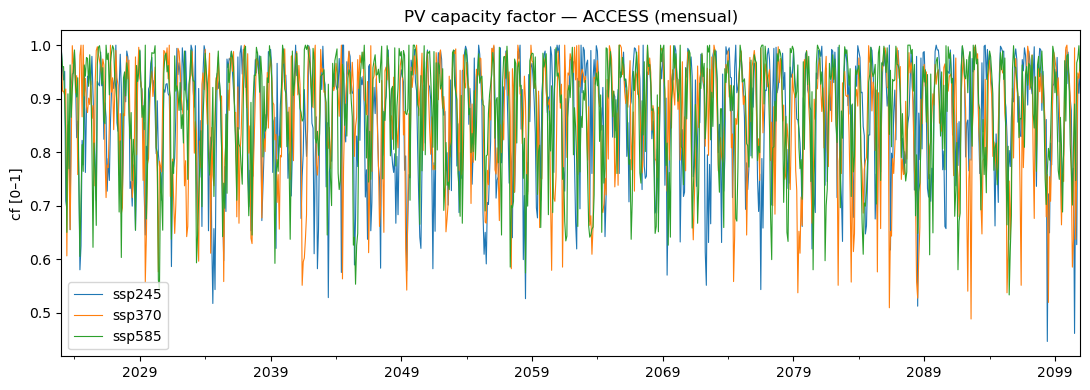

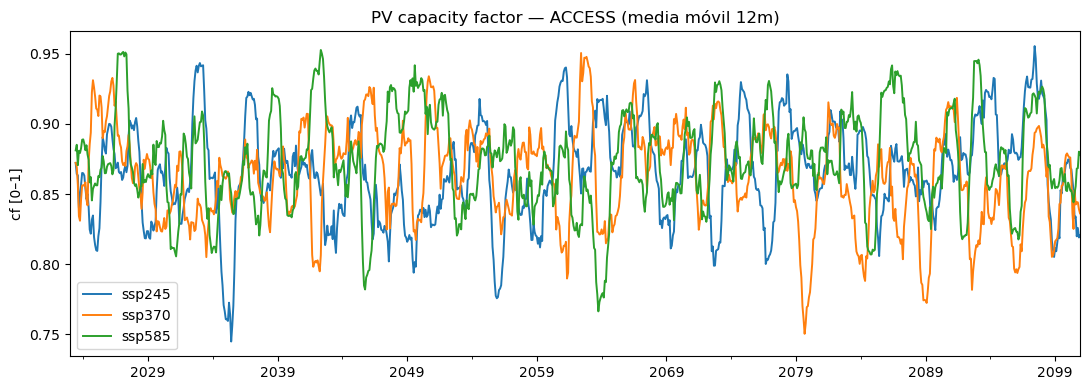


=== Estadísticos básicos — ACCESS ===


,ssp245,ssp370,ssp585
count,936.000000,936.000000,936.000000
mean,0.865220,0.863099,0.873913
std,0.111192,0.109645,0.107232
min,0.446000,0.488000,0.533000
5%,0.653000,0.646500,0.657500
50%,0.901000,0.894500,0.911000
95%,0.994000,0.992000,0.997000
max,1.000000,1.000000,1.000000



=== Climatología mensual (cf medio por mes) — ACCESS ===


,ssp245,ssp370,ssp585
01,0.976269,0.966551,0.972179
02,0.947782,0.938949,0.949051
03,0.904667,0.899628,0.910269
04,0.853936,0.861577,0.860628
05,0.793821,0.796410,0.796077
06,0.747474,0.748692,0.792308
07,0.799923,0.790103,0.810295
08,0.796513,0.788090,0.790500
09,0.796167,0.809436,0.806064
10,0.882487,0.881590,0.898859



=== Medias anuales — ACCESS ===


,ssp245,ssp370,ssp585
time,,,
2023-01-01,0.865083,0.856167,0.888750
2024-01-01,0.813750,0.919500,0.857583
2025-01-01,0.896333,0.912667,0.871333
2026-01-01,0.865750,0.883250,0.949500
2027-01-01,0.895583,0.858333,0.858083
...,...,...,...
2096-01-01,0.926333,0.865917,0.904500
2097-01-01,0.930917,0.890750,0.924667
2098-01-01,0.805167,0.809500,0.860750


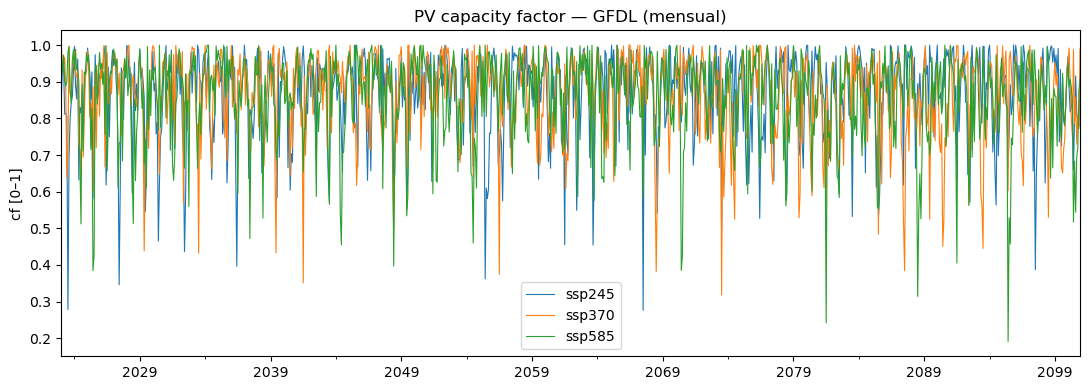

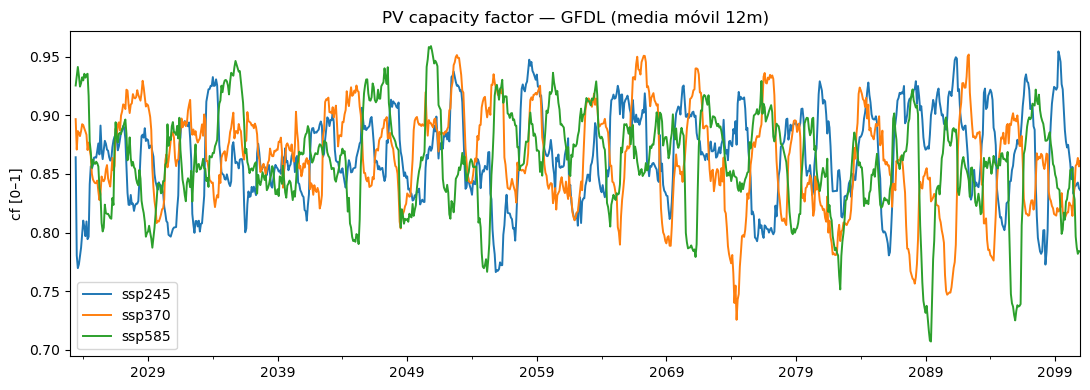


=== Estadísticos básicos — GFDL ===


,ssp245,ssp370,ssp585
count,936.000000,936.000000,936.000000
mean,0.865614,0.863668,0.860533
std,0.116955,0.113616,0.118918
min,0.276000,0.318000,0.191000
5%,0.631750,0.650750,0.630000
50%,0.897000,0.898000,0.892500
95%,0.996000,0.996000,0.993500
max,1.000000,1.000000,1.000000



=== Climatología mensual (cf medio por mes) — GFDL ===


,ssp245,ssp370,ssp585
01,0.963718,0.964821,0.953641
02,0.932346,0.930538,0.931910
03,0.904564,0.903962,0.901769
04,0.892859,0.881679,0.889141
05,0.803256,0.803795,0.807962
06,0.759679,0.780808,0.755244
07,0.749667,0.756038,0.745808
08,0.888218,0.865833,0.869897
09,0.810833,0.810359,0.821526
10,0.854128,0.847590,0.833154



=== Medias anuales — GFDL ===


,ssp245,ssp370,ssp585
time,,,
2023-01-01,0.798333,0.892333,0.932333
2024-01-01,0.864167,0.842083,0.858500
2025-01-01,0.869750,0.846167,0.815917
2026-01-01,0.885333,0.899750,0.883917
2027-01-01,0.818417,0.915083,0.855667
...,...,...,...
2096-01-01,0.927667,0.814333,0.895667
2097-01-01,0.781833,0.867083,0.898500
2098-01-01,0.924167,0.815750,0.856333


In [19]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ==== 1) Configura rutas ====
file_map = {
    "access": {
        "ssp245": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_access_ssp245.csv",
        "ssp370": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_access_ssp370.csv",
        "ssp585": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_access_ssp585.csv",
    },
    "gfdl": {
        "ssp245": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_gfdl_ssp245.csv",
        "ssp370": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_gfdl_ssp370.csv",
        "ssp585": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_gfdl_ssp585.csv",
    },
}

# ==== 2) Utilidades ====
def read_cf_csv(path: str) -> pd.Series:
    """Lee CSV de cf. Detecta columna de tiempo/valor de forma robusta."""
    df = pd.read_csv(path)
    # Columna de tiempo
    time_col = "timesteps" if "timesteps" in df.columns else df.columns[0]
    # Columna de valores
    val_col  = "cf" if "cf" in df.columns else df.columns[-1]
    idx = pd.to_datetime(df[time_col])
    ser = pd.Series(pd.to_numeric(df[val_col], errors="coerce").values, index=idx, name=Path(path).stem)
    # Asegurar orden por fecha y frecuencia mensual
    ser = ser.sort_index()
    return ser

def make_model_df(model_key: str) -> pd.DataFrame:
    """Concatena las tres series (ssp245/370/585) en un DataFrame."""
    series = {}
    for ssp, path in file_map[model_key].items():
        s = read_cf_csv(path).asfreq("MS")  # fuerza frecuencia inicio de mes
        series[ssp] = s
    df = pd.DataFrame(series)
    return df

def plot_model(df: pd.DataFrame, model_label: str, show_rolling=True, win=12):
    """Gráfico de líneas: cf mensual (y rolling 12m si se quiere)."""
    # Figura 1: series mensuales (posible ruido)
    plt.figure(figsize=(11, 4))
    df.plot(ax=plt.gca(), linewidth=0.8)
    plt.title(f"PV capacity factor — {model_label} (mensual)")
    plt.ylabel("cf [0–1]")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

    if show_rolling:
        # Figura 2: suavizado (media móvil 12 meses)
        plt.figure(figsize=(11, 4))
        df.rolling(win, min_periods=win//2).mean().plot(ax=plt.gca(), linewidth=1.4)
        plt.title(f"PV capacity factor — {model_label} (media móvil {win}m)")
        plt.ylabel("cf [0–1]")
        plt.xlabel("")
        plt.tight_layout()
        plt.show()

def monthly_climatology(df: pd.DataFrame) -> pd.DataFrame:
    """Climatología mensual (promedio por mes del año)."""
    clim = df.groupby(df.index.month).mean()
    clim.index = ["%02d" % m for m in clim.index]  # 01..12
    return clim

def annual_means(df: pd.DataFrame) -> pd.DataFrame:
    """Promedios anuales por SSP."""
    return df.resample("YS").mean()

# ==== 3) Cargar, graficar y mostrar tablas resumen ====
for model in ["access", "gfdl"]:
    df = make_model_df(model)

    # Gráficos: mensual y rolling 12m
    plot_model(df, model_label=model.upper(), show_rolling=True, win=12)

    # Tablas de chequeo rápido
    print(f"\n=== Estadísticos básicos — {model.upper()} ===")
    stats = df.describe(percentiles=[0.05, 0.5, 0.95])
    display(stats)

    print(f"\n=== Climatología mensual (cf medio por mes) — {model.upper()} ===")
    clim = monthly_climatology(df)
    display(clim)

    print(f"\n=== Medias anuales — {model.upper()} ===")
    ann = annual_means(df)
    display(ann)


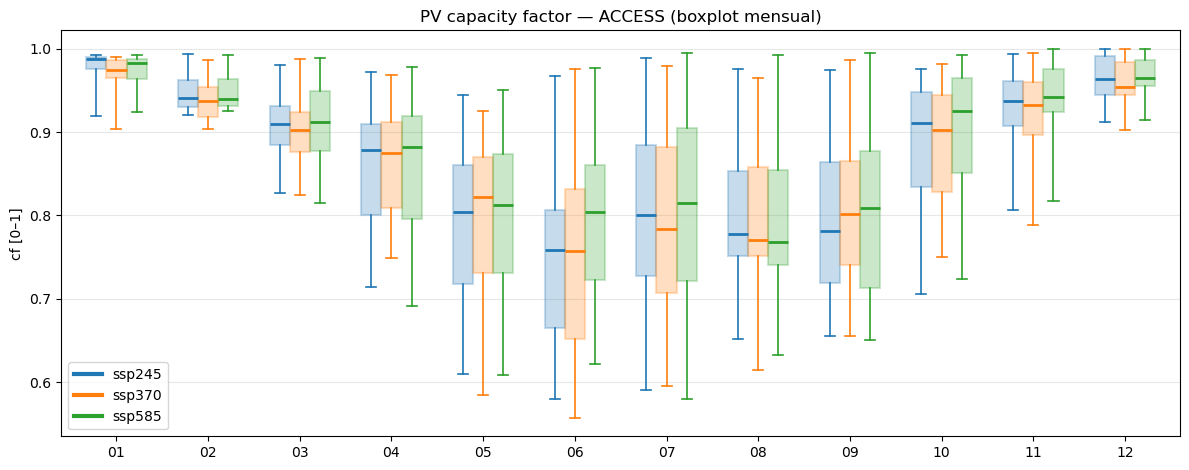

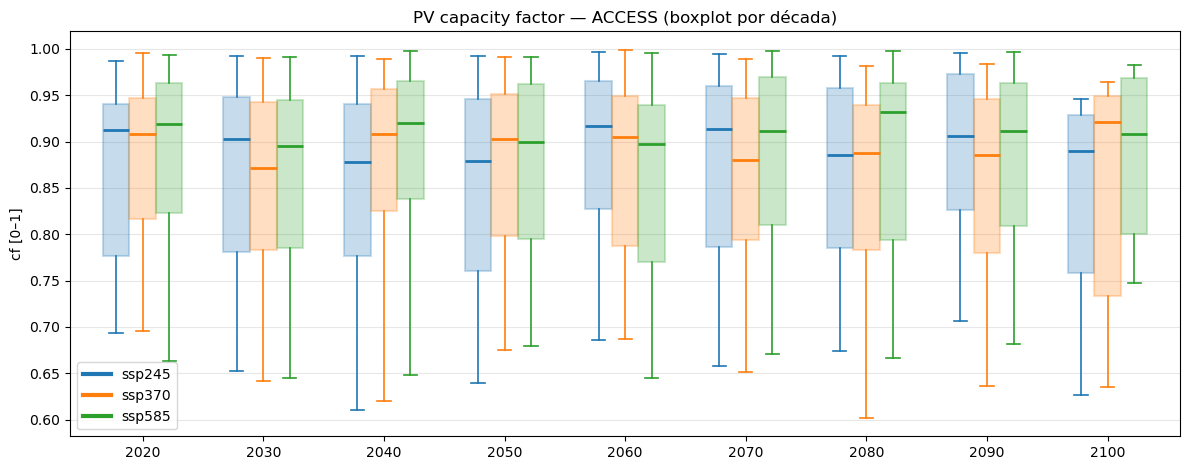

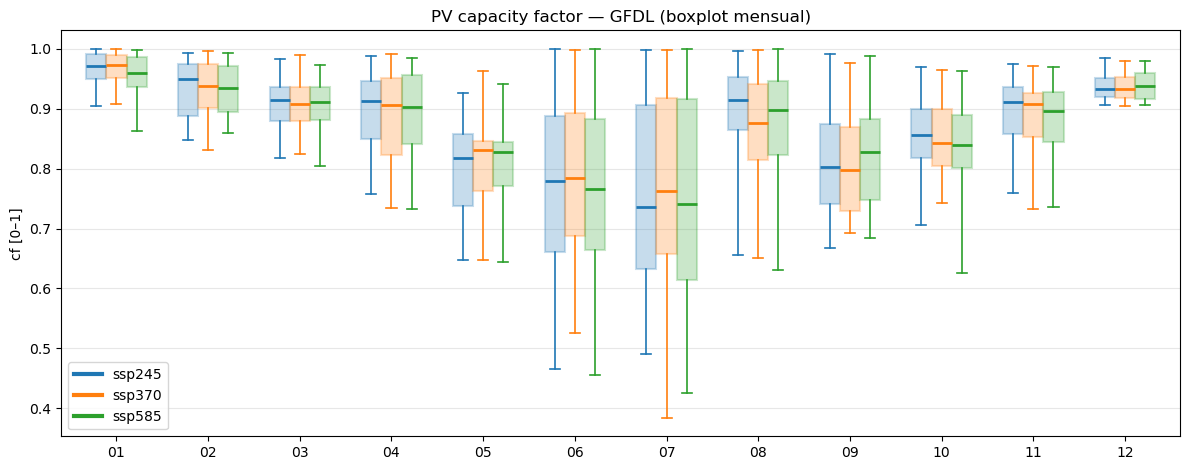

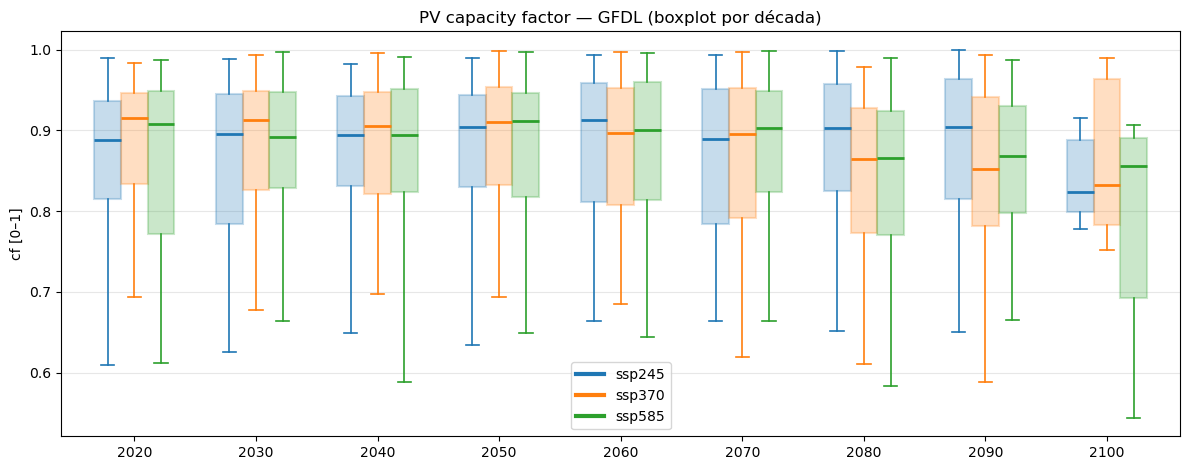

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === rutas de tus CSV ===
file_map = {
    "ACCESS": {
        "ssp245": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_access_ssp245.csv",
        "ssp370": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_access_ssp370.csv",
        "ssp585": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_access_ssp585.csv",
    },
    "GFDL": {
        "ssp245": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_gfdl_ssp245.csv",
        "ssp370": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_gfdl_ssp370.csv",
        "ssp585": "/home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/qm/pv_cf_gfdl_ssp585.csv",
    },
}

def read_cf_csv(path: str) -> pd.Series:
    df = pd.read_csv(path)
    tcol = "timesteps" if "timesteps" in df.columns else df.columns[0]
    vcol = "cf" if "cf" in df.columns else df.columns[-1]
    s = pd.Series(pd.to_numeric(df[vcol], errors="coerce").values,
                  index=pd.to_datetime(df[tcol]))
    return s.asfreq("MS").sort_index()

def make_model_df(model_key: str) -> pd.DataFrame:
    return pd.DataFrame({ssp: read_cf_csv(p) for ssp, p in file_map[model_key].items()})

def grouped_boxplot(df: pd.DataFrame, group: str, title: str):
    import matplotlib.pyplot as plt
    import numpy as np

    if group == "month":
        groups = np.arange(1, 13)
        selector = df.index.month
        xticklabels = [f"{m:02d}" for m in groups]
    elif group == "decade":
        selector = (df.index.year // 10) * 10
        groups = np.sort(selector.unique())
        xticklabels = groups.astype(str)
    else:
        raise ValueError("group debe ser 'month' o 'decade'.")

    ssps = ["ssp245", "ssp370", "ssp585"]
    # Colores consistentes con tus líneas
    palette = {"ssp245": "tab:blue", "ssp370": "tab:orange", "ssp585": "tab:green"}

    width = 0.22
    base = np.arange(len(groups)) + 1
    offsets = [-width, 0.0, width]

    plt.figure(figsize=(12, 4.8))
    for k, ssp in enumerate(ssps):
        data = [df.loc[selector == g, ssp].dropna().values for g in groups]
        pos = base + offsets[k]
        color = palette[ssp]
        plt.boxplot(
            data,
            positions=pos,
            widths=width,
            manage_ticks=False,
            showfliers=False,
            whis=(5, 95),
            patch_artist=True,  # << clave para colorear el interior
            boxprops=dict(facecolor=color, alpha=0.25, edgecolor=color, linewidth=1.5),
            medianprops=dict(color=color, linewidth=2.0),
            whiskerprops=dict(color=color, linewidth=1.2),
            capprops=dict(color=color, linewidth=1.2),
        )

    plt.xticks(base, xticklabels)
    plt.title(title)
    plt.ylabel("cf [0–1]")
    plt.xlim(base[0]-0.6, base[-1]+0.6)
    plt.grid(axis="y", alpha=0.3)

    # Leyenda “manual”
    for ssp in ssps:
        plt.plot([], [], color=palette[ssp], label=ssp, linewidth=3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Ejecuta: boxplots por mes y por década para cada modelo ===
for model in ["ACCESS", "GFDL"]:
    df = make_model_df(model)
    grouped_boxplot(df, group="month",  title=f"PV capacity factor — {model} (boxplot mensual)")
    grouped_boxplot(df, group="decade", title=f"PV capacity factor — {model} (boxplot por década)")
